This subject of this project is the housing crisis in Ireland.
- Is this also seen in other European countries?
- Are new housing projects building enough to meet current demand?

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [139]:
import glob
from copy import deepcopy

# Data Ingestion

## IE Data First
This will later be replaced by mongodb calls using json versions of this data.

In [140]:
# https://data.gov.ie/dataset/ndq01-new-dwelling-completions/resource/8fdc8f87-88ca-43f7-aa16-dbc3a52cacde
df_ie_ndq1_orig = pd.read_csv('./datasets/ie/NDQ01.csv')

# https://data.gov.ie/dataset/ndq03-new-dwelling-completions/resource/45701f7f-1192-406f-980f-a8ee23862147
df_ie_ndq3_orig = pd.read_csv('./datasets/ie/NDQ03.csv')

# https://data.gov.ie/dataset/ndq05-new-dwelling-completion/resource/108d82d0-43f1-4574-9e47-bb54f078fd84
df_ie_ndq5_orig = pd.read_csv('./datasets/ie/NDQ05.csv')

# https://data.gov.ie/dataset/ndq06-new-dwelling-completion/resource/0b5041bb-9f52-4b54-8c8d-0000306e74e2
df_ie_ndq6_orig = pd.read_csv('./datasets/ie/NDQ06.csv')

# https://data.gov.ie/dataset/ndq07-new-dwelling-completion/resource/f9cf710c-b9cb-485f-b986-4b76cf6ef045
df_ie_ndq7_orig = pd.read_csv('./datasets/ie/NDQ07.csv')

# UK data

In [141]:
# https://www.ons.gov.uk/businessindustryandtrade/constructionindustry/datasets/outputintheconstructionindustrysubnationalandsubsector
df_uk_con_sub_nat_orig = pd.read_excel('./datasets/uk/bulletindataset6.xlsx')

# https://www.ons.gov.uk/businessindustryandtrade/constructionindustry/datasets/outputintheconstructionindustryallworksummary
df_uk_con_all_work_orig = pd.read_excel('./datasets/uk/bulletindataset1.xlsx')

# https://www.ons.gov.uk/businessindustryandtrade/constructionindustry/datasets/outputintheconstructionindustry
df_uk_con_output_orig = pd.read_excel('./datasets/uk/bulletindataset2.xlsx')

# EU data

In [142]:
# https://ec.europa.eu/eurostat/web/products-datasets/-/ei_bsbu_q_r2
df_eu_con_qtr_orig = pd.read_csv('./datasets/eu/ei_bsbu_q_r2.tsv')

# https://ec.europa.eu/eurostat/web/products-datasets/-/ei_isbu_q
df_eu_con_qtr_index_orig = pd.read_csv('./datasets/eu/ei_isbu_q.tsv')

# https://ec.europa.eu/eurostat/web/products-datasets/-/sts_copr_q
df_eu_con_qtr_prod_orig = pd.read_csv('./datasets/eu/sts_copr_q.tsv')

# Data Cleansing & Preparation

## IE Data

In [143]:
df_ie_ndq1 = deepcopy(df_ie_ndq1_orig)

In [144]:
df_ie_ndq1.head()

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,UNIT,VALUE
0,NDQ01,New Dwelling Completions,20111,2011Q1,06,Single house,Number,1156
1,NDQ01,New Dwelling Completions,20111,2011Q1,07,Scheme house,Number,447
2,NDQ01,New Dwelling Completions,20111,2011Q1,08,Apartment,Number,272
3,NDQ01,New Dwelling Completions,20111,2011Q1,-,All house types,Number,1875
4,NDQ01,New Dwelling Completions,20112,2011Q2,06,Single house,Number,1194


In [145]:
df_ie_ndq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   UNIT             392 non-null    object
 7   VALUE            392 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 24.6+ KB


In [146]:
# Statistic & Statistic Label represent the same data, so we can drop STATISTC and keep the label
df_ie_ndq1.pivot_table(index='STATISTIC Label',  columns='STATISTIC', values='VALUE', aggfunc='sum')

STATISTIC,NDQ01,NDQ01C02
STATISTIC Label,,
New Dwelling Completions,339994.0,NaN
Seasonally Adjusted New Dwelling Completions,NaN,340507.0


In [147]:
# Type of House is mapped to C02342V02816, so we can drop C02342V02816.
df_ie_ndq1.pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0)

C02342V02816,-,06,07,08
Type of House,,,,
All house types,340248,0,0,0
Apartment,0,0,0,65615
Scheme house,0,0,171317,0
Single house,0,103321,0,0


In [148]:
# The sum of Apartment, Scheme house and Single house does not equal All house types
df_ie_ndq1[df_ie_ndq1['Type of House']!='All house types'].pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0).sum().sum()

340253

In [149]:
df_ndq1_house_totals = df_ie_ndq1.groupby(['Type of House'])['VALUE'].sum()

In [150]:
df_ie_ndq1['type_comp'] = df_ie_ndq1['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [151]:
df_ndq1_temp = df_ie_ndq1.pivot_table(index='Quarter',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq1_temp.head()

type_comp,All,All house types
Quarter,,
2011Q1,4078,4078
2011Q2,3692,3692
2011Q3,3370,3370
2011Q4,3008,3009
2012Q1,2466,2466


In [152]:
df_ndq1_temp['diff'] = df_ndq1_temp['All'] - df_ndq1_temp['All house types']
df_ndq1_temp[df_ndq1_temp['diff'] != 0]

type_comp,All,All house types,diff
Quarter,,,
2011Q4,3008,3009,-1
2012Q4,2679,2678,1
2013Q2,2325,2324,1
2013Q4,2779,2778,1
2014Q1,2354,2353,1
2014Q3,2794,2793,1
2015Q3,4036,4037,-1
2016Q2,4796,4795,1
2016Q3,4914,4915,-1


In [153]:
# There are 17 quarters where the total does not match the sum of the 3 housing types.
# For now, we will leave the data whole and decide whether to keep/exclude the totals when the rest of the data is explored.
df_ndq1_temp[df_ndq1_temp['diff'] != 0].count()

type_comp
All                17
All house types    17
diff               17
dtype: int64

In [154]:
# UNIT is an unnecessary column as there is just a single value 'Number'.
df_ie_ndq1.pivot_table(index='UNIT',  columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0)

Type of House,All house types,Apartment,Scheme house,Single house
UNIT,,,,
Number,340248,65615,171317,103321


<Axes: xlabel='Quarter', ylabel='TLIST(Q1)'>

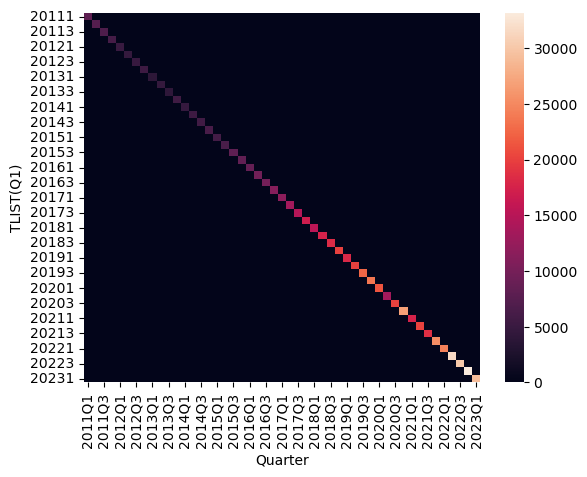

In [155]:
# TLIST(Q1) appears to be the same as Quarter
df_qtr_pivot = df_ie_ndq1.pivot_table(index='TLIST(Q1)',  columns='Quarter', values='VALUE', aggfunc='sum', fill_value=0)
sns.heatmap(df_qtr_pivot)

In [156]:
# Test that all the values in TLIST(Q1) are the same as in Quarter but with an added Q in the second last position
assert((df_ie_ndq1['Quarter'].str.replace('Q', '').astype('str') ==df_ie_ndq1['TLIST(Q1)'].astype('str')).all())

In [157]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'UNIT', 'type_comp']

In [158]:
df_ie_ndq1_clean = df_ie_ndq1.drop(list_cols_to_drop, axis=1)

In [159]:
df_ie_ndq1_clean.head()

,STATISTIC Label,Quarter,Type of House,VALUE
0,New Dwelling Completions,2011Q1,Single house,1156
1,New Dwelling Completions,2011Q1,Scheme house,447
2,New Dwelling Completions,2011Q1,Apartment,272
3,New Dwelling Completions,2011Q1,All house types,1875
4,New Dwelling Completions,2011Q2,Single house,1194


In [160]:
# I don't think I'll end up needing this but keep it for now and decide when joining the dataframes.

df_ie_ndq1_pivot = df_ie_ndq1_clean.pivot_table(index=['STATISTIC Label', 'Quarter'], columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0).reset_index()

In [161]:
df_ie_ndq1_pivot.head()

Type of House,STATISTIC Label,Quarter,All house types,Apartment,Scheme house,Single house
0,New Dwelling Completions,2011Q1,1875,272,447,1156
1,New Dwelling Completions,2011Q2,1791,217,380,1194
2,New Dwelling Completions,2011Q3,1687,185,305,1197
3,New Dwelling Completions,2011Q4,1641,148,226,1267
4,New Dwelling Completions,2012Q1,1131,123,211,797


## IE DF no.2

In [162]:
df_ie_ndq3 = deepcopy(df_ie_ndq3_orig)

In [163]:
df_ie_ndq3.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,C02106V02545,Urban and Rural,UNIT,VALUE
0,NDQ03,New Dwelling Completions,20111,2011Q1,-,All house types,1,Urban areas,Number,841
1,NDQ03,New Dwelling Completions,20111,2011Q1,-,All house types,5,Rural areas,Number,1033
2,NDQ03,New Dwelling Completions,20111,2011Q1,06,Single house,1,Urban areas,Number,152
3,NDQ03,New Dwelling Completions,20111,2011Q1,06,Single house,5,Rural areas,Number,1004
4,NDQ03,New Dwelling Completions,20111,2011Q1,07,Scheme house,1,Urban areas,Number,422
5,NDQ03,New Dwelling Completions,20111,2011Q1,07,Scheme house,5,Rural areas,Number,25
6,NDQ03,New Dwelling Completions,20111,2011Q1,08,Apartment,1,Urban areas,Number,267
7,NDQ03,New Dwelling Completions,20111,2011Q1,08,Apartment,5,Rural areas,Number,4
8,NDQ03,New Dwelling Completions,20112,2011Q2,-,All house types,1,Urban areas,Number,706
9,NDQ03,New Dwelling Completions,20112,2011Q2,-,All house types,5,Rural areas,Number,1081


In [164]:
df_ie_ndq3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   C02106V02545     392 non-null    int64 
 7   Urban and Rural  392 non-null    object
 8   UNIT             392 non-null    object
 9   VALUE            392 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 30.8+ KB


In [165]:
# Check if all house types is equal to the sum of urban and rural areas
df_ie_ndq3['type_comp'] = df_ie_ndq3['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [166]:
df_ndq3_temp = df_ie_ndq3.pivot_table(index=['Quarter', 'Urban and Rural'],  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq3_temp.head()

type_comp                 All  All house types
Quarter Urban and Rural                       
2011Q1  Rural areas      1033             1033
        Urban areas       841              841
2011Q2  Rural areas      1081             1081
        Urban areas       706              706
2011Q3  Rural areas      1085             1085

In [167]:
df_ndq3_temp['diff'] = df_ndq3_temp['All'] - df_ndq3_temp['All house types']
df_ndq3_temp

type_comp                 All  All house types  diff
Quarter Urban and Rural                             
2011Q1  Rural areas      1033             1033     0
        Urban areas       841              841     0
2011Q2  Rural areas      1081             1081     0
        Urban areas       706              706     0
2011Q3  Rural areas      1085             1085     0
...                       ...              ...   ...
2022Q3  Urban areas      6087             6087     0
2022Q4  Rural areas      1339             1339     0
        Urban areas      7804             7804     0
2023Q1  Rural areas       967              967     0
        Urban areas      5749             5749     0

[98 rows x 3 columns]

In [168]:
# Totals are equal but the number is less than half of the number from the first dataframe.
df_ie_ndq3.pivot_table(index='UNIT',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)

type_comp,All,All house types
UNIT,,
Number,169985,169985


In [169]:
df_ndq3_house_totals = df_ie_ndq3.groupby(['Type of House'])['VALUE'].sum()

In [170]:
# Approx half of each house type from ndq1 is included in ndq3 - including totals.
df_ndq3_temp = pd.concat([df_ndq1_house_totals, df_ndq3_house_totals], axis=1)
df_ndq3_temp.columns = ['ndq1', 'ndq3']
df_ndq3_temp['diff'] = df_temp['ndq1'] - df_temp['ndq3']
df_ndq3_temp['diff %'] = df_temp['diff'] / df_temp['ndq1']
print(df_ndq3_temp)

                   ndq1    ndq3    diff    diff %
Type of House                                    
All house types  340248  169985  170263  0.500409
Apartment         65615   32819   32796  0.499825
Scheme house     171317   85621   85696  0.500219
Single house     103321   51545   51776  0.501118


In [171]:
# Urban and Rural is mapped to C02106V02545, so we can drop C02106V02545.
df_ie_ndq3.pivot_table(index='Urban and Rural',  columns='C02106V02545', values='VALUE', aggfunc='sum', fill_value=0)

C02106V02545,1,5
Urban and Rural,,
Rural areas,0,87864
Urban areas,252106,0


In [172]:
# Add C02106V02545 to the existing drop_cols list as the other columns are also present.
list_cols_to_drop.append('C02106V02545')

In [173]:
df_ie_ndq3_clean = df_ie_ndq3.drop(list_cols_to_drop, axis=1)

In [174]:
df_ie_ndq3_pivot = df_ie_ndq3_clean.pivot_table(index=['STATISTIC Label', 'Quarter', 'Type of House'], columns='Urban and Rural', values='VALUE', aggfunc='sum', fill_value=0).reset_index()

In [175]:
df_ie_ndq3_clean.head()

,STATISTIC Label,Quarter,Type of House,Urban and Rural,VALUE
0,New Dwelling Completions,2011Q1,All house types,Urban areas,841
1,New Dwelling Completions,2011Q1,All house types,Rural areas,1033
2,New Dwelling Completions,2011Q1,Single house,Urban areas,152
3,New Dwelling Completions,2011Q1,Single house,Rural areas,1004
4,New Dwelling Completions,2011Q1,Scheme house,Urban areas,422


In [176]:
df_ie_ndq3_pivot.head()

Urban and Rural,STATISTIC Label,Quarter,Type of House,Rural areas,Urban areas
0,New Dwelling Completions,2011Q1,All house types,1033,841
1,New Dwelling Completions,2011Q1,Apartment,4,267
2,New Dwelling Completions,2011Q1,Scheme house,25,422
3,New Dwelling Completions,2011Q1,Single house,1004,152
4,New Dwelling Completions,2011Q2,All house types,1081,706


## IE DF no.3

In [177]:
df_ie_ndq5 = deepcopy(df_ie_ndq5_orig)

In [178]:
df_ie_ndq5.head()

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168


In [179]:
df_ie_ndq5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        1568 non-null   object
 1   STATISTIC Label  1568 non-null   object
 2   TLIST(Q1)        1568 non-null   int64 
 3   Quarter          1568 non-null   object
 4   C03789V04537     1568 non-null   object
 5   Local Authority  1568 non-null   object
 6   UNIT             1568 non-null   object
 7   VALUE            1568 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 98.1+ KB


In [180]:
# For each value in C03789V04537, theres is one value for Local Authority, we can drop C03789V04537
df_ie_ndq5.groupby(['Local Authority'])['C03789V04537'].nunique()

Local Authority
Carlow County Council                    1
Cavan County Council                     1
Clare County Council                     1
Cork City Council                        1
Cork County Council                      1
Donegal County Council                   1
Dublin City Council                      1
Dún Laoghaire Rathdown County Council    1
Fingal County Council                    1
Galway City Council                      1
Galway County Council                    1
Ireland                                  1
Kerry County Council                     1
Kildare County Council                   1
Kilkenny County Council                  1
Laois County Council                     1
Leitrim County Council                   1
Limerick City & County Council           1
Longford County Council                  1
Louth County Council                     1
Mayo County Council                      1
Meath County Council                     1
Monaghan County Council               

In [181]:
df_ie_ndq5['auth_comp'] = df_ie_ndq5['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [182]:
# Sum of all 
df_ie_ndq5.pivot_table(index='UNIT',  columns='auth_comp', values='VALUE', aggfunc='sum', fill_value=0)

auth_comp,CC,Ireland
UNIT,,
Number,169997,169997


In [183]:
# Compare the totals for each dataframe at the highest agg level in the data
ndq1_total = df_ie_ndq1[df_ie_ndq1['Type of House']=='All house types']['VALUE'].sum()
ndq3_total = df_ie_ndq3[df_ie_ndq3['Type of House']=='All house types']['VALUE'].sum()
ndq5_total = df_ie_ndq5[df_ie_ndq5['Local Authority']=='Ireland']['VALUE'].sum()

In [184]:
# NDQ3 & 5 are similar but both are still ~50% of NDQ1
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}")
print(ndq1_total - ndq5_total)

NDQ1: 340248, NDQ3: 169985, NDQ5: 169997
170251


https://www.citizensinformation.ie/en/government_in_ireland/national_government/local_and_regional_government/functions_of_local_authorities.html  
Differentiating between City and County council will have no material as it is not possible to determine if a specific council  type controls rural or urban planning

In [185]:
df_ie_ndq5['CC_name'] = df_ie_ndq5['Local Authority'].str.split(' C', n=1).str[0]
df_ie_ndq5.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE,auth_comp,CC_name
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875,Ireland,Ireland
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39,CC,Cork
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52,CC,Clare
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61,CC,Cavan
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168,CC,Cork
5,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17,CC,Carlow
6,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,72,CC,Dublin
7,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,30,CC,Dún Laoghaire Rathdown
8,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,118,CC,Donegal
9,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,144,CC,Fingal


In [186]:
df_ie_ndq5['CC_name'].unique()

array(['Ireland', 'Cork', 'Clare', 'Cavan', 'Carlow', 'Dublin',
       'Dún Laoghaire Rathdown', 'Donegal', 'Fingal', 'Galway', 'Kildare',
       'Kilkenny', 'Kerry', 'Longford', 'Louth', 'Limerick', 'Leitrim',
       'Laois', 'Meath', 'Monaghan', 'Mayo', 'Offaly', 'Roscommon',
       'South Dublin', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
       'Wicklow', 'Wexford'], dtype=object)

In [193]:
dict_county_mapping = {'Dún Laoghaire Rathdown':"Dublin", 'Fingal':"Dublin", 'South Dublin':"Dublin"}

In [196]:
df_ie_ndq5['county'] = df_ie_ndq5['CC_name'].str.strip().replace(dict_county_mapping)


In [198]:
df_ie_ndq5.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE,auth_comp,CC_name,county
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875,Ireland,Ireland,Ireland
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39,CC,Cork,Cork
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52,CC,Clare,Clare
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61,CC,Cavan,Cavan
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168,CC,Cork,Cork
5,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17,CC,Carlow,Carlow
6,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,72,CC,Dublin,Dublin
7,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,30,CC,Dún Laoghaire Rathdown,Dublin
8,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,118,CC,Donegal,Donegal
9,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,144,CC,Fingal,Dublin


In [216]:
# Duplicate rows for Dublin
df_ie_ndq5[['STATISTIC Label', 'Quarter', 'county', 'VALUE']].head(10)

,STATISTIC Label,Quarter,county,VALUE
0,New Dwelling Completion,2011Q1,Ireland,1875
1,New Dwelling Completion,2011Q1,Cork,39
2,New Dwelling Completion,2011Q1,Clare,52
3,New Dwelling Completion,2011Q1,Cavan,61
4,New Dwelling Completion,2011Q1,Cork,168
5,New Dwelling Completion,2011Q1,Carlow,17
6,New Dwelling Completion,2011Q1,Dublin,72
7,New Dwelling Completion,2011Q1,Dublin,30
8,New Dwelling Completion,2011Q1,Donegal,118
9,New Dwelling Completion,2011Q1,Dublin,144


In [218]:
# After mapping the county names, we need to aggregate to the county level to avoid duplicate values
df_ie_ndq5_cleaned = df_ie_ndq5.groupby(['STATISTIC Label', 'Quarter', 'county'])['VALUE'].sum().reset_index()

In [220]:
df_ie_ndq5_cleaned.head(10)

,STATISTIC Label,Quarter,county,VALUE
0,New Dwelling Completion,2011Q1,Carlow,17
1,New Dwelling Completion,2011Q1,Cavan,61
2,New Dwelling Completion,2011Q1,Clare,52
3,New Dwelling Completion,2011Q1,Cork,207
4,New Dwelling Completion,2011Q1,Donegal,118
5,New Dwelling Completion,2011Q1,Dublin,287
6,New Dwelling Completion,2011Q1,Galway,108
7,New Dwelling Completion,2011Q1,Ireland,1875
8,New Dwelling Completion,2011Q1,Kerry,62
9,New Dwelling Completion,2011Q1,Kildare,126


In [222]:
ndq5_cleaned_total = df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['county']!='Ireland']['VALUE'].sum()

In [224]:
# Test if pre-rollup values = post rollup values
assert(ndq5_total == ndq5_cleaned_total)

## IE DF no.4

In [225]:
df_ie_ndq6 = deepcopy(df_ie_ndq6_orig)

In [227]:
df_ie_ndq6.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,C03789V04537,Local Authority,UNIT,VALUE
0,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,8
1,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,45
2,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,21
3,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,145
4,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17
5,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,6
6,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,16
7,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,82
8,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,17
9,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a5-13a3-e055-000000000001,Galway County Council,Number,92


In [228]:
# From previous cleaning we know that C02342V02816 & C03789V04537 map to type of house & local authority.
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'C03789V04537', 'UNIT']
df_ie_ndq6 = df_ie_ndq6.drop(list_cols_to_drop, axis=1)

In [229]:
df_ie_ndq6.head(10)

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE
0,New Dwelling Completion,2011Q1,Single house,Cork City Council,8
1,New Dwelling Completion,2011Q1,Single house,Clare County Council,45
2,New Dwelling Completion,2011Q1,Single house,Cavan County Council,21
3,New Dwelling Completion,2011Q1,Single house,Cork County Council,145
4,New Dwelling Completion,2011Q1,Single house,Carlow County Council,17
5,New Dwelling Completion,2011Q1,Single house,Dublin City Council,6
6,New Dwelling Completion,2011Q1,Single house,Dún Laoghaire Rathdown County Council,16
7,New Dwelling Completion,2011Q1,Single house,Donegal County Council,82
8,New Dwelling Completion,2011Q1,Single house,Fingal County Council,17
9,New Dwelling Completion,2011Q1,Single house,Galway County Council,92


# Add county cleaning function